In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [2]:
from scipy.optimize import minimize
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
import seaborn as sns

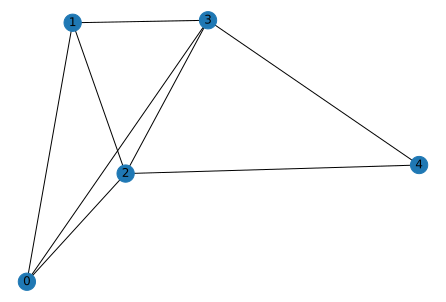

In [3]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [4]:
def initialization(circ):
    for i in range(circ.N):
        circ.apply_gate('H',i,gate_round=0)
    return circ
def cost_unitary(circ,gamma,gate_round):
    for edge in graph:
        circ.apply_gate('RZZ', edge[2]*gamma,edge[0], edge[1], gate_round=gate_round)
    return circ
def mixture_unitary(circ,alpha,gate_round):
    for i in range(circ.N):
        circ.apply_gate('RX', alpha, i, gate_round=gate_round)
    return circ
def anasatz(gammas, alphas, n_layers,n_nodes):
    N = n_nodes
    circ = qtn.CircuitMPS(N)
    circ = initialization(circ)
    for i in range(n_layers):
        circ = cost_unitary(circ,gammas[i],gate_round=i)
        circ = mixture_unitary(circ,alphas[i],gate_round=i)
    return circ
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas


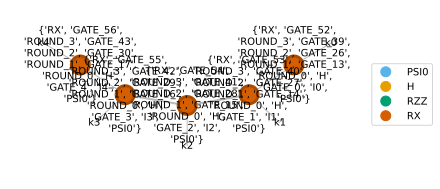

In [5]:
p=4
n=n_nodes
init_params = np.array([float(random.randint(-314, 314))/float(10000) for i in range(0, 2*p)])
gammas, alphas = create_params(init_params)
circ = anasatz(gammas, alphas, p,n)
circ.psi.draw(color=['PSI0', 'H', 'RZZ', 'RX'])

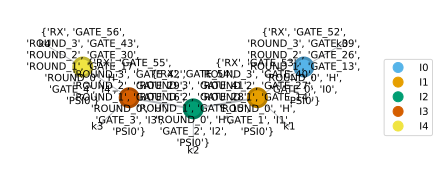

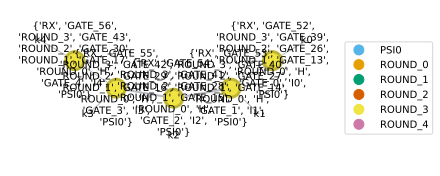

In [6]:
circ.psi.draw(color=[f'I{i}' for i in range(5)])
circ.psi.draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(5)])

In [8]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
    
)

In [9]:
ZZ = qu.pauli('Z') & qu.pauli('Z')
local_exp_rehs = [circ.local_expectation_rehearse(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]

In [10]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective
bounds = ([(-np.pi, np.pi)] * p + [(-np.pi, np.pi)] * p)
bopt = Optimizer(bounds)

In [11]:
def cost_function(params):
    gammas, alphas = create_params(params)
    circ = anasatz(gammas, alphas, p,n)
    cost = 0
    ZZ = qu.pauli('Z') & qu.pauli('Z')
    expns = [circ.local_expectation(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    cost = 0.5*(sum(expns).real)
    return cost

In [12]:
import tqdm
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, cost_function(x))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


Optimized cost is :-3.4577148470085772


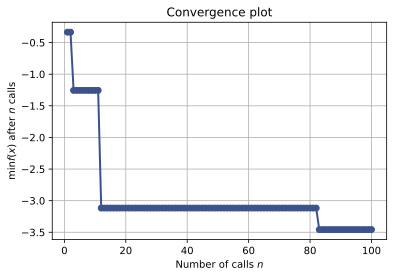

In [13]:
plot_convergence(res);
print("Optimized cost is :{}".format(res.fun))

In [19]:
def create_bitstrings(opt_params):
    opt_gammas, opt_alphas = create_params(opt_params)
    opt_circ = anasatz(opt_gammas, opt_alphas, p,n)
    bitstrings = Counter(opt_circ.sample(1000))
    return bitstrings, opt_circ

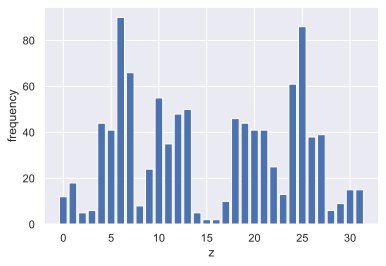

Z with maximum frequency is  :6


In [20]:
bitstrings, opt_circ = create_bitstrings(res.x)
x=[]
y=[]
for key in bitstrings.keys():
    num = 0
    
    for i in range(len(key)):
        num = num + pow(2,i)*int(key[len(key)-1-i])
    x.append(num)
    y.append(bitstrings[key])
    if bitstrings[key] == max(y):
        maximum = num
sns.set()
plt.bar(x,y,color='b')
plt.xlabel("z")
plt.ylabel("frequency")
plt.show()
print("Z with maximum frequency is  :{}".format(maximum))